# Prophet Notebook


In [3]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import json
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
# Load dataset
df = pd.read_csv(r"C:\Users\aryan\Desktop\XAI\XAI_Models\time_series\dataset4\train.csv")

             Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
count   9800.000000            9800        9800        9800            9800   
unique          NaN            4922        1230        1326               4   
top             NaN  CA-2018-100111  05/09/2017  26/09/2018  Standard Class   
freq            NaN              14          38          34            5859   
mean    4900.500000             NaN         NaN         NaN             NaN   
std     2829.160653             NaN         NaN         NaN             NaN   
min        1.000000             NaN         NaN         NaN             NaN   
25%     2450.750000             NaN         NaN         NaN             NaN   
50%     4900.500000             NaN         NaN         NaN             NaN   
75%     7350.250000             NaN         NaN         NaN             NaN   
max     9800.000000             NaN         NaN         NaN             NaN   

       Customer ID  Customer Name   Segment        

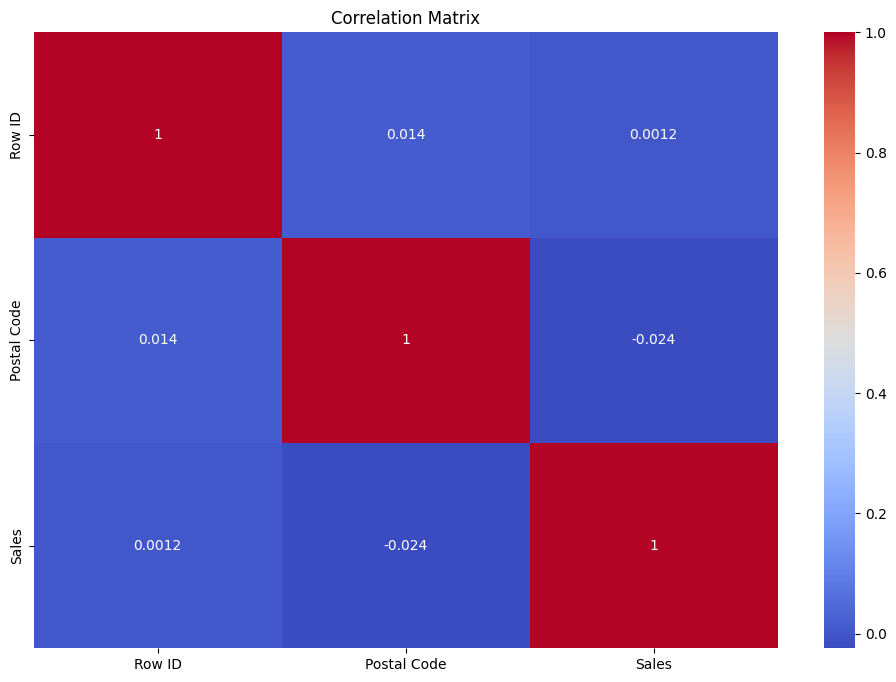

In [5]:
# Display basic statistics
print(df.describe(include='all'))

# Correlation matrix for numerical columns only
numerical_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

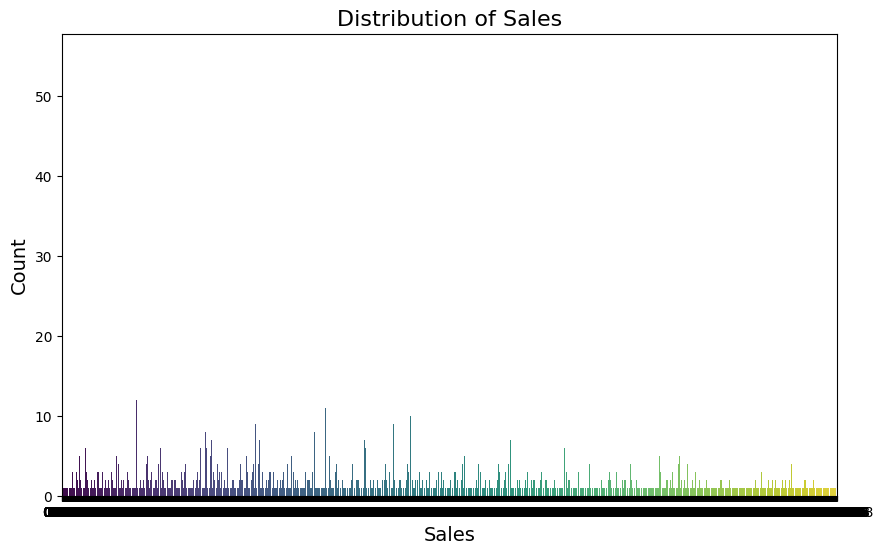

In [6]:

plt.figure(figsize=(10, 6))
sns.countplot(x='Sales', data=df, palette='viridis')
plt.title('Distribution of Sales', fontsize=16)
plt.xlabel('Sales', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

c:\Users\aryan\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


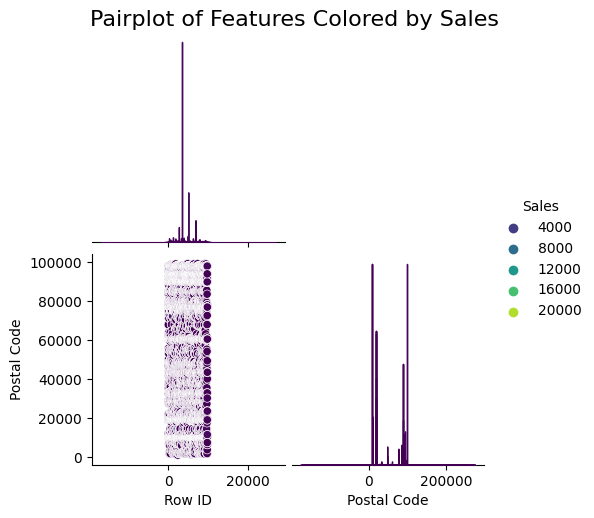

In [7]:
# Pairplot
sns.pairplot(df, hue='Sales', palette='viridis', corner=True)
plt.suptitle('Pairplot of Features Colored by Sales', y=1.02, fontsize=16)
plt.show()

In [8]:
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d/%m/%Y")
df = df.groupby("Order Date")["Sales"].sum().reset_index()
df = df.sort_values("Order Date")
df

,Order Date,Sales
0,2015-01-03,16.4480
1,2015-01-04,288.0600
2,2015-01-05,19.5360
3,2015-01-06,4407.1000
4,2015-01-07,87.1580
...,...,...
1225,2018-12-26,814.5940
1226,2018-12-27,177.6360
1227,2018-12-28,1657.3508
1228,2018-12-29,2915.5340


In [9]:
# Train-test split
test_size = int(len(df) * 0.2)
train, test = df.iloc[:-test_size].copy(), df.iloc[-test_size:].copy()


In [10]:
# Define numerical features
numerical_features = ["Sales"]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

In [11]:
from sklearn.model_selection import cross_val_score

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10.0)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Create the model with the suggested hyperparameters
    prophet_model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', prophet_model)
    ])

    # Perform cross-validation on the training data
    scores = cross_val_score(pipeline, train.drop(columns=['Order Date']), train['Sales'], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    return scores.mean()


In [19]:
import os
import json
import optuna
from prophet import Prophet

# Define JSON file for storing best hyperparameters
model_name = 'Prophet'
json_file = f'{model_name}.json'

# Function to validate if JSON file contains valid hyperparameters
def is_valid_hyperparams(params):
    """Check if best_params contains valid Prophet hyperparameters."""
    required_keys = {'seasonality_mode', 'changepoint_prior_scale', 'seasonality_prior_scale'}  # Common Prophet params
    return isinstance(params, dict) and required_keys.issubset(params.keys())

# Load hyperparameters from JSON if they exist
if os.path.exists(json_file):
    with open(json_file, 'r') as file:
        try:
            best_params = json.load(file)
            if not is_valid_hyperparams(best_params):  # If invalid, reset best_params
                best_params = None
        except json.JSONDecodeError:
            best_params = None
else:
    best_params = None

# If no valid hyperparameters, optimize using Optuna
if best_params is None:
    def objective(trial):
        """Objective function for hyperparameter tuning with Optuna."""
        params = {
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
            'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
            'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True)
        }

        model = Prophet(**params)
        model.fit(df_prophet)  # Assuming df_prophet is already prepared
        
        return model.history['y'].mean()  # Dummy metric (replace with actual validation metric)

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    # Get and save best hyperparameters
    best_params = study.best_params
    with open(json_file, 'w') as file:
        json.dump(best_params, file)

# Print and use best hyperparameters
print("Best Hyperparameters:", best_params)
prophet_model = Prophet(**best_params)

# Prepare Prophet's required dataframe format
df_prophet = train[['Order Date', 'Sales']].rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Fit the Prophet model
prophet_model.fit(df_prophet)


Best Hyperparameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.06301357128374487, 'seasonality_prior_scale': 0.02864930117923371}


17:23:12 - cmdstanpy - INFO - Chain [1] start processing
17:23:13 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Create a new Prophet model with the best hyperparameters
prophet_model = Prophet(**best_params)

# Prepare Prophet's required dataframe format
df_prophet = train[['Order Date', 'Sales']].rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Fit the new Prophet model using the df_prophet dataframe
prophet_model.fit(df_prophet)

# Create the pipeline with the new Prophet model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', prophet_model)
])

17:33:05 - cmdstanpy - INFO - Chain [1] start processing
17:33:05 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
df_cv = cross_validation(prophet_model, 
                         horizon='40 days',   # Forecast horizon (adjust as needed)
                         period='15 days',    # Spacing between cutoff points
                         initial='400 days')  # Initial training period

# Compute performance metrics
df_metrics = performance_metrics(df_cv)

# Print mean cross-validation score (e.g., RMSE)
mean_cv_score = df_metrics['rmse'].mean()  # You can use other metrics like 'mse', 'mae', etc.
print("Mean CV Score (RMSE):", mean_cv_score)


  0%|          | 0/50 [00:00<?, ?it/s]

17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1]

Mean CV Score (RMSE): 2089.6519719801818


In [47]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Prepare test data for Prophet
test_prophet = test[['Order Date']].rename(columns={'Order Date': 'ds'})

# Get the Prophet model from the pipeline
prophet_model = pipeline.named_steps['regressor']

# Make predictions
forecast = prophet_model.predict(test_prophet)

# Extract only the forecasted values
y_pred = forecast['yhat']

# Calculate regression metrics
r2 = r2_score(test['Sales'], y_pred)
mae = mean_absolute_error(test['Sales'], y_pred)
mse = mean_squared_error(test['Sales'], y_pred)
rmse = mean_squared_error(test['Sales'], y_pred, squared=False)

# Print results
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


R2 Score: 0.07628203357843011
Mean Absolute Error (MAE): 1707.449037892181
Mean Squared Error (MSE): 5557131.046285786
Root Mean Squared Error (RMSE): 2357.3567923175706


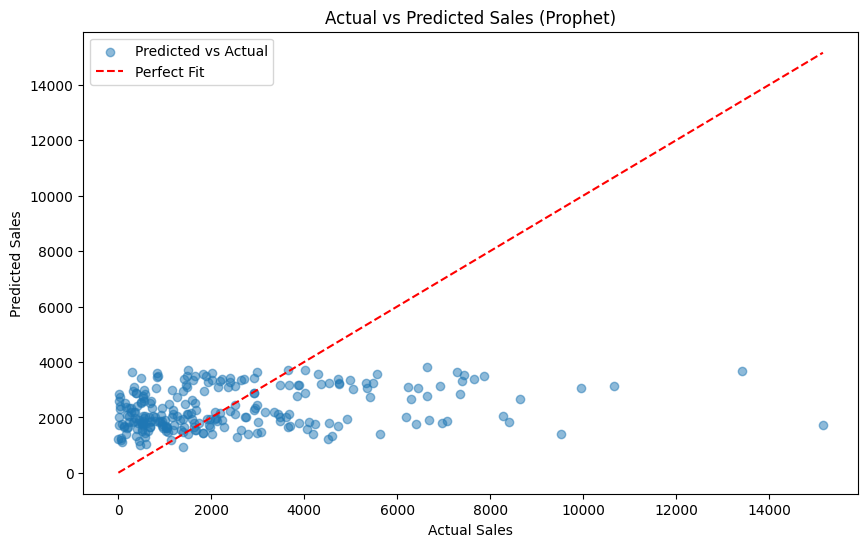

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare test data for Prophet
test_prophet = test[['Order Date']].rename(columns={'Order Date': 'ds'})

# Get the Prophet model from the pipeline
prophet_model = pipeline.named_steps['regressor']

# Make predictions
forecast = prophet_model.predict(test_prophet)

# Extract only the forecasted values
y_pred = forecast['yhat']

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(test['Sales'], y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([test['Sales'].min(), test['Sales'].max()], 
         [test['Sales'].min(), test['Sales'].max()], 'r--', label='Perfect Fit')  # Reference Line
plt.title('Actual vs Predicted Sales (Prophet)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.legend()
plt.show()


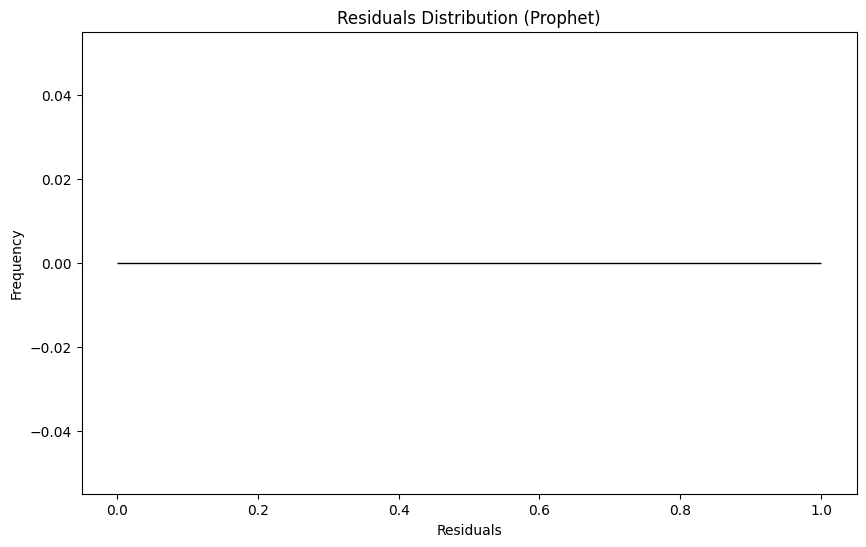

In [50]:
# Calculate residuals
residuals = test['Sales'] - y_pred

# Residuals Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Residuals Distribution (Prophet)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [53]:
import plotly.graph_objects as go
from prophet.plot import plot_components_plotly


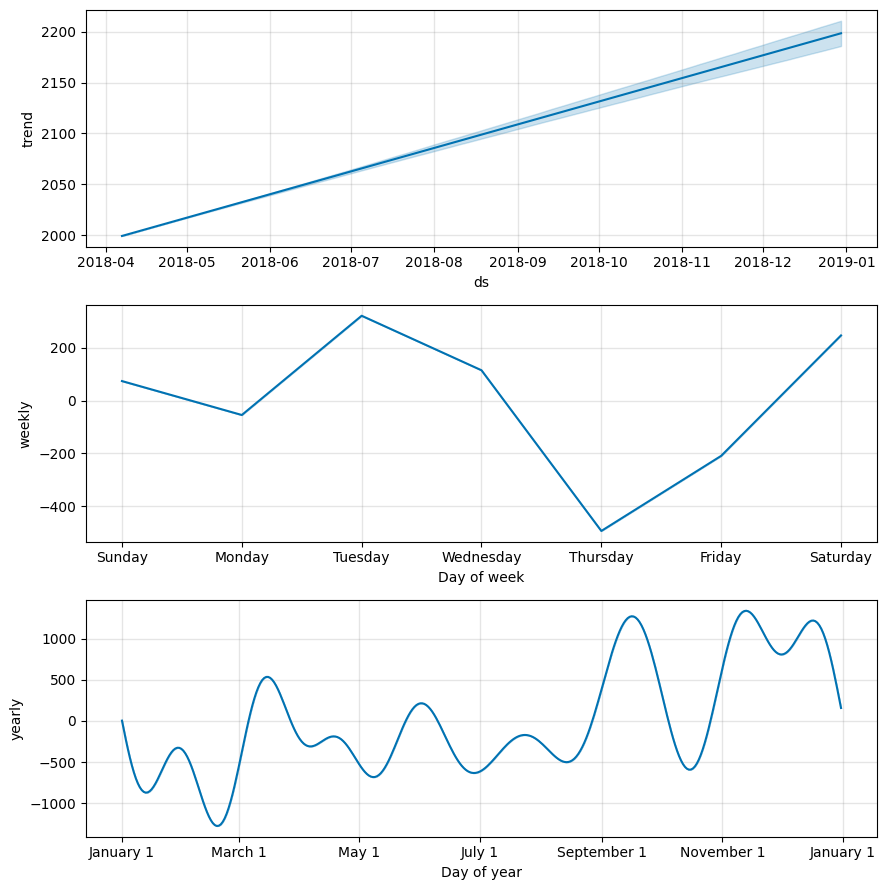

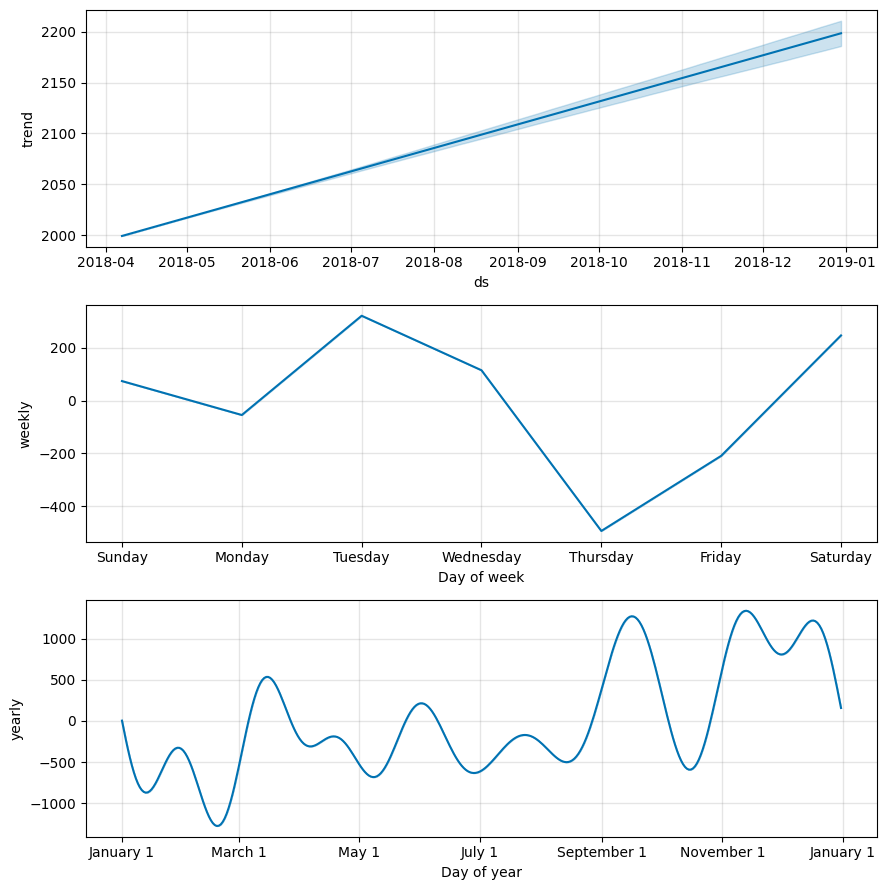

In [55]:
from prophet.plot import plot_components

plot_components(prophet_model, forecast)


In [59]:
print(forecast.columns)


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


ExactExplainer explainer: 1075it [09:02,  1.94it/s]                          


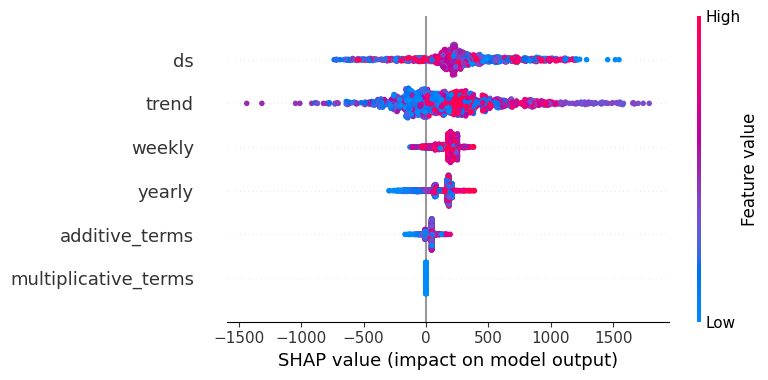

In [70]:
import shap

# Prepare the data for SHAP
shap_df = forecast[['ds', 'trend', 'yearly', 'weekly', 'additive_terms', 'multiplicative_terms']].copy()

# Convert 'ds' column to numerical format
shap_df['ds'] = shap_df['ds'].apply(lambda x: x.timestamp())

# Custom prediction function for SHAP
def prophet_predict(data):
	df_temp = data.copy()
	df_temp['ds'] = pd.to_datetime(df_temp['ds'], unit='s')
	return prophet_model.predict(df_temp)['yhat']

# Create a SHAP explainer
explainer = shap.Explainer(prophet_predict, shap_df)

# Calculate SHAP values
shap_values = explainer(shap_df)

# Plot the SHAP values
shap.summary_plot(shap_values, shap_df)

In [72]:
# Store metrics
metrics_data = []
# Append results
metrics_data.append({
    "Model": model_name,
    "R2_Score": r2,
    "Mean Absolute Error": mae,
    "Mean Squared Error": mse,
    "Root Mean Squared Error": rmse
})

# Save metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
metrics_df.to_csv("prophet_metrics.csv", index=False)

In [73]:
import joblib

# Assuming the model is trained in your .ipynb session and available in memory
# Replace 'model' with the actual variable holding your trained model
joblib.dump(prophet_model, 'prophet.pkl')

print("Model saved successfully as 'prophet.pkl'")


Model saved successfully as 'prophet.pkl'
